In [2]:
!pip install -U imbalanced-learn xgboost

#Import and loading dataset
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay, roc_curve, roc_auc_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier

df = pd.read_csv('/content/drive/MyDrive/Student Performance Dataset/student-por.csv')

df.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,4,0,11,11
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,2,9,11,11
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,6,12,13,12
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,0,14,14,14
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,0,11,13,13


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 649 entries, 0 to 648
Data columns (total 33 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   school      649 non-null    object
 1   sex         649 non-null    object
 2   age         649 non-null    int64 
 3   address     649 non-null    object
 4   famsize     649 non-null    object
 5   Pstatus     649 non-null    object
 6   Medu        649 non-null    int64 
 7   Fedu        649 non-null    int64 
 8   Mjob        649 non-null    object
 9   Fjob        649 non-null    object
 10  reason      649 non-null    object
 11  guardian    649 non-null    object
 12  traveltime  649 non-null    int64 
 13  studytime   649 non-null    int64 
 14  failures    649 non-null    int64 
 15  schoolsup   649 non-null    object
 16  famsup      649 non-null    object
 17  paid        649 non-null    object
 18  activities  649 non-null    object
 19  nursery     649 non-null    object
 20  higher    

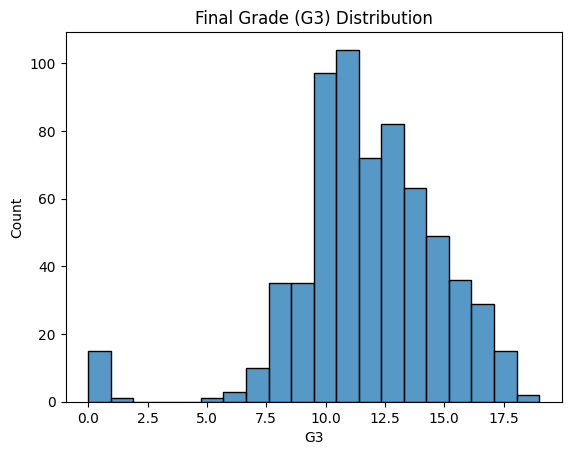

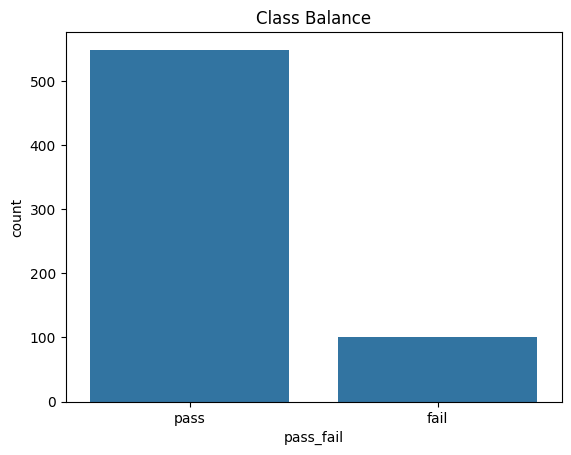

In [3]:
#2. EDA
print(df.info())
print(df.describe())
sns.histplot(df['G3'], bins=20)
plt.title("Final Grade (G3) Distribution")
plt.show()

#Creating a classification label
df['pass_fail'] = df['G3'].apply(lambda x: 'pass' if x >= 10 else 'fail')
sns.countplot(x='pass_fail', data=df)
plt.title("Class Balance")
plt.show()

In [4]:
#3. Preprocessing

#Label encode binary classification categorical columns
binary_cols = [col for col in df.columns if df[col].nunique() == 2 and df[col].dtype == 'object']
le = LabelEncoder()
for col in binary_cols:
    df[col] = le.fit_transform(df[col])

#one-hot encode remaining categoricals
df = pd.get_dummies(df, drop_first=True)

#Feature engineering
df['total_alcohol'] = df['Dalc'] + df['Walc']
df['parent_edu'] = df['Medu'] + df['Fedu']


#Recreate or ensure 'pass_fail' column exists
df['pass_fail'] = df['G3'].apply(lambda x: 'pass' if x >= 10 else 'fail')
df = df.dropna(subset=['pass_fail'])
y = df['pass_fail'].map({'fail': 0, 'pass': 1})
print("Any NaNs in y?", y.isna().sum())

#Drop G2 but keep G1 for improved prediction
X = df.drop(['G3', 'pass_fail', 'G2'], axis=1)

#Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

#Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#Apply SMOTE to handle class imbalance
smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train_scaled, y_train)


Any NaNs in y? 0



Model: Decision Tree
Accuracy: 0.7846153846153846
Classification Report:
               precision    recall  f1-score   support

           0       0.35      0.45      0.39        20
           1       0.89      0.85      0.87       110

    accuracy                           0.78       130
   macro avg       0.62      0.65      0.63       130
weighted avg       0.81      0.78      0.80       130



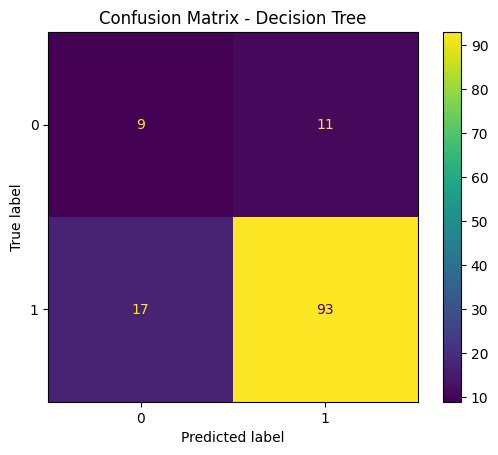


Model: Random Forest
Accuracy: 0.8076923076923077
Classification Report:
               precision    recall  f1-score   support

           0       0.35      0.30      0.32        20
           1       0.88      0.90      0.89       110

    accuracy                           0.81       130
   macro avg       0.61      0.60      0.61       130
weighted avg       0.80      0.81      0.80       130



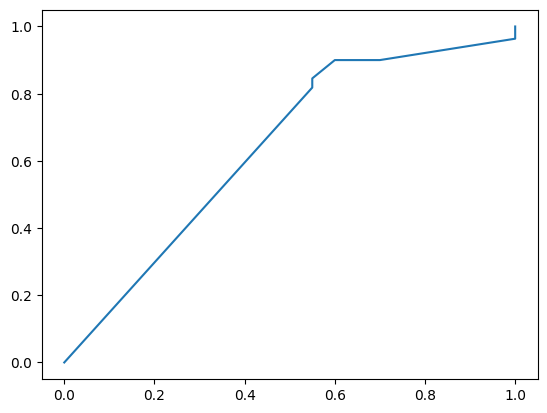

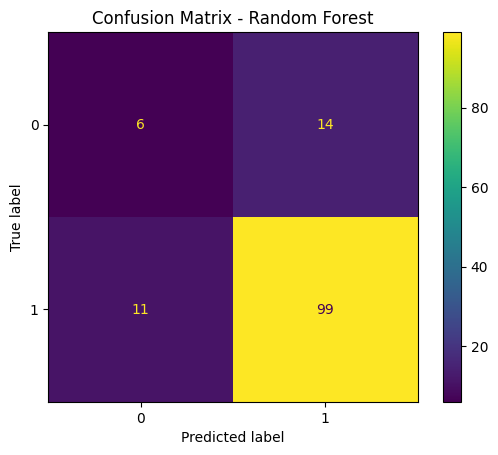

Random Forest Cross-validated AUC: 0.9978951446280991


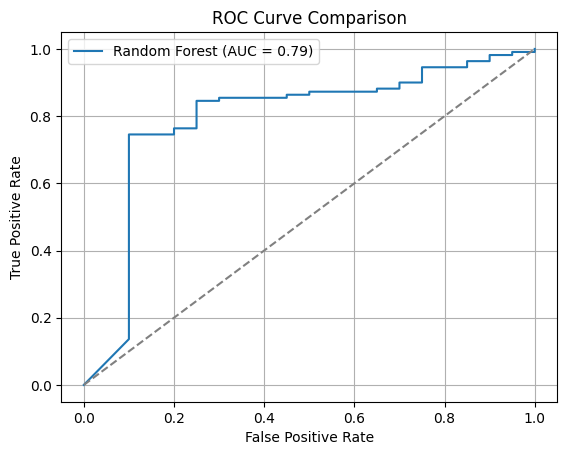

In [5]:
#4. Hyperparameter tuning + modeling
param_grid_dt = {'max_depth': [3, 5, 10, None], 'min_samples_split': [2, 5, 10]}
param_grid_rf = {'n_estimators': [50, 100], 'max_depth': [5, 10, None]}

dt_grid = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid_dt, cv=5)
rf_grid = GridSearchCV(RandomForestClassifier(random_state=42), param_grid_rf, cv=5)

dt_grid.fit(X_train_bal, y_train_bal)
rf_grid.fit(X_train_bal, y_train_bal)

best_dt = dt_grid.best_estimator_
best_rf = rf_grid.best_estimator_

#Evaluate on test data
models = {'Decision Tree': best_dt, 'Random Forest': best_rf}

for name, model in models.items():
    preds = model.predict(X_test_scaled)
    proba = model.predict_proba(X_test_scaled)[:, 1]
    print(f"\nModel: {name}")
    print("Accuracy:", accuracy_score(y_test, preds))
    print("Classification Report:\n", classification_report(y_test, preds))
    ConfusionMatrixDisplay.from_predictions(y_test, preds)
    plt.title(f"Confusion Matrix - {name}")
    plt.show()

    #ROC Curve
    fpr, tpr, _ = roc_curve(y_test, proba)
    auc = roc_auc_score(y_test, proba)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {auc:.2f})")

#Cross validating AUC score for Random Forest
rf_scores = cross_val_score(best_rf, X_train_bal, y_train_bal, cv=5, scoring='roc_auc')
print("Random Forest Cross-validated AUC:", rf_scores.mean())

#Final ROC Curve Plot
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.title("ROC Curve Comparison")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.show()

/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [04:57:12] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



Model: XGBoost
Accuracy: 0.8538461538461538
Classification Report:
               precision    recall  f1-score   support

           0       0.52      0.60      0.56        20
           1       0.93      0.90      0.91       110

    accuracy                           0.85       130
   macro avg       0.72      0.75      0.74       130
weighted avg       0.86      0.85      0.86       130



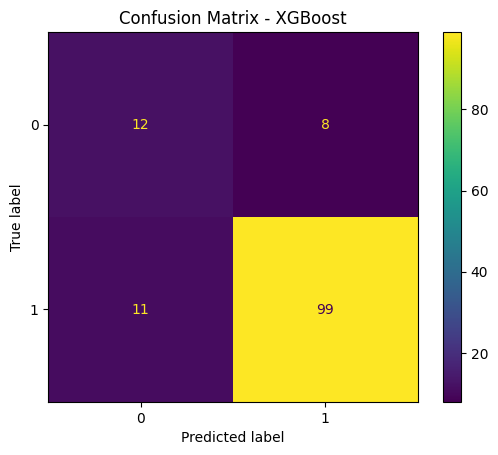

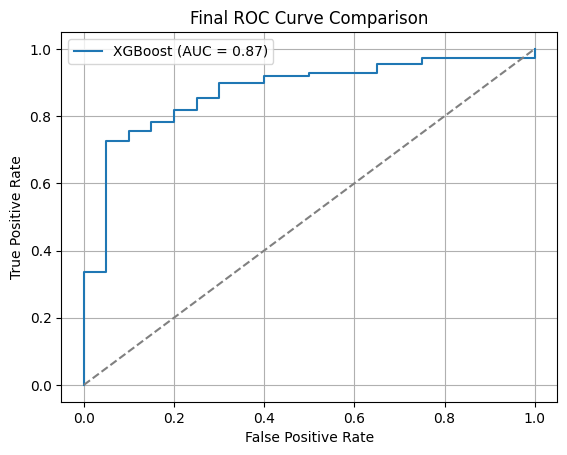

In [6]:
#.5 - Adding an addtional model: XGBoost just to see if results improve
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb.fit(X_train_bal, y_train_bal)

xgb_preds = xgb.predict(X_test_scaled)
xgb_proba = xgb.predict_proba(X_test_scaled)[:, 1]

print("\nModel: XGBoost")
print("Accuracy:", accuracy_score(y_test, xgb_preds))
print("Classification Report:\n", classification_report(y_test, xgb_preds))
ConfusionMatrixDisplay.from_predictions(y_test, xgb_preds)
plt.title("Confusion Matrix - XGBoost")
plt.show()

fpr, tpr, _ = roc_curve(y_test, xgb_proba)
auc = roc_auc_score(y_test, xgb_proba)
plt.plot(fpr, tpr, label=f"XGBoost (AUC = {auc:.2f})")

plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.title("Final ROC Curve Comparison")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.show()


Dataset and Task:

Classified Students into two catagories:
Pass (G3 >= 10) vs Fail (G3 < 10)

Model Performance:

Random Forest:

Test Accuracy = 0.808
Test F1-macro = 0.61
Test AUC = 0.79

Decision Tree:

Test Accuracy = 0.785
Test F1-macro = 0.63

XGBoost:

Test Accuracy = 0.854
Test F1-macro = 0.74
Test AUC = 0.87

XGBoost was the best performing model. This was added in there to see if the model could improve more.


*   F1-macro = 0.74, AUC = 0.87, Accuracy = 85%
*   Confusion Matrix shows balanced performance across both classes
*   Able to correctly identify 60% of failing students

Random Forest was the best model not including XGBoost.

*   F1-macro = 0.61, AUC = 0.79
*   High accuracy but poor performance on minority class (fail)
*   Tends to predict "pass" more often, misclassifying 70% of fails.
*   Indicates strong performance on the majority of class but limitied learning about minority class.

Decision Tree



*   F1-macro = 0.63, lower AUC than others
*   Performed decently but showed more variance.


*   Least stable, more likely to overfit or underfit depending on tree depth.
*   List item



Caveats


*   Test set was skewed: only~20 failing students vs. ~110 passing.

*  SMOTE helps, but real-world test data might behave differently.


